Fine-tuning model EfficientNetV2-B0

In [24]:
import numpy as np
import os
import json
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0

In [35]:
# Thông số cấu hình
BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)
EPOCHS = 20              
BASE_DIR = '/kaggle/input/fresh-rotten-fruits/dataset'

TRAIN_PATH = os.path.join(BASE_DIR, 'train')
VAL_PATH = os.path.join(BASE_DIR, 'test')
WEIGHTS_PATH = os.path.join(BASE_DIR, 'efficientnetv2-b0_notop.h5')

CLASS_INDICES_PATH = '/kaggle/working/class_indices.json'

CHECKPOINT_PATH = '/kaggle/working/model_efficientnetv2b0.keras'

In [29]:
# Lớp tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    zoom_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    brightness_range = [0.8, 1.2]
)

val_datagen = ImageDataGenerator(
    rescale = 1.0/255.0
)

In [30]:
# Áp dụng tăng cường vào dữ liệu
train_data = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'sparse'
)

val_data = train_datagen.flow_from_directory(
    VAL_PATH,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'sparse'
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [31]:
# Lưu lại ánh xạ nhãn để tái sử dụng
with open(CLASS_INDICES_PATH, 'w', encoding='utf-8-sig') as wf:
    fruit_class_indices = train_data.class_indices
    reversed_class_indices = {value: key for key, value in fruit_class_indices.items()}
    json.dump(reversed_class_indices, wf)

reversed_class_indices

{0: 'freshapples',
 1: 'freshbanana',
 2: 'freshoranges',
 3: 'rottenapples',
 4: 'rottenbanana',
 5: 'rottenoranges'}

In [ ]:
# Minh họa dữ liệu đã tăng cường
def plot_random_image():
    images, labels = next(train_data)
    plt.figure(figsize=(20, 10))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        label_index = np.argmax(labels[i])
        plt.xlabel(reversed_class_indices[label_index])

plot_random_image()


In [32]:
# Khởi tạo model EfficientNetV2-B0 đã huấn luyện sẵn, trọng số từ ImageNet
# Loại bỏ lớp fully connected cũ
base_model = EfficientNetV2B0(
    weights = WEIGHTS_PATH,
    include_top = False,
    input_tensor = Input(shape=(*IMAGE_SHAPE, 3))
)

# Đóng băng các lớp ConvNet
for layer in base_model.layers:
    layer.trainable = False

# lấy ra output của ConvNet trong EfficientNetV2-B0
x = base_model.output

# GlobalPooling trước khi đưa vòa lớp FC 
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(reversed_class_indices), activation='softmax')(x)

# Dựng model bằng việc nối ConvNet của EfficientNetV2-B0 và base_model.output
model = Model(inputs=base_model.input, outputs=x)

In [33]:
# Cấu hình model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# Tạo checkpoint lưu trọng số tốt nhất khi training
checkpoint = ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Huấn luyện
his = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2319 - loss: 1.7723
Epoch 1: val_loss improved from inf to 1.76667, saving model to /kaggle/working/model_efficientnetv2b0.keras
682/682 ━━━━━━━━━━━━━━━━━━━━ 187s 275ms/step - accuracy: 0.2319 - loss: 1.7723 - val_accuracy: 0.1964 - val_loss: 1.7667
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.2256 - loss: 1.7682
Epoch 2: val_loss improved from 1.76667 to 1.75535, saving model to /kaggle/working/model_efficientnetv2b0.keras
682/682 ━━━━━━━━━━━━━━━━━━━━ 181s 266ms/step - accuracy: 0.2256 - loss: 1.7682 - val_accuracy: 0.2528 - val_loss: 1.7554
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.2403 - loss: 1.7630
Epoch 3: val_loss improved from 1.75535 to 1.74864, saving model to /kaggle/working/model_efficientnetv2b0.keras
682/682 ━━━━━━━━━━━━━━━━━━━━ 180s 264ms/step - accuracy: 0.2403 - loss: 1.7630 - val_accuracy: 0.2824 - val_loss: 1.7486
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━

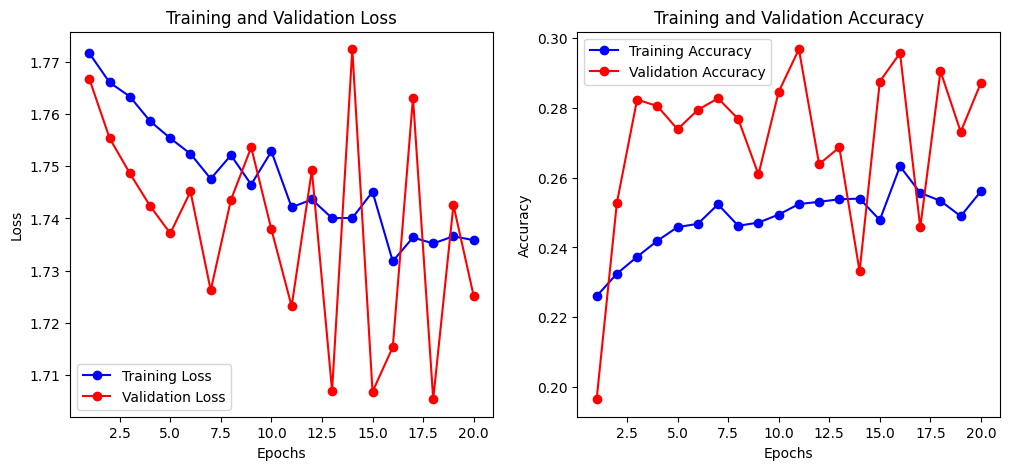

In [38]:
# Số epoch từ history
epochs = np.arange(1, len(his.history['loss']) + 1)

# Vẽ Loss và Accuracy
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, his.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, his.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
acc = his.history.get('accuracy', his.history.get('acc'))
val_acc = his.history.get('val_accuracy', his.history.get('val_acc'))

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()